In [24]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Variational Quantum Linear Solver {#vqls}
=================================

::: {.meta}
:property=\"og:description\": Implementing the variational quantum
linear solver to solve a system of linear equation with a quantum
device. :property=\"og:image\":
<https://pennylane.ai/qml/_images/vqls_zoom.png>
:::

::: {.related}
tutorial\_coherent\_vqls Coherent Variational Quantum Linear Solver
:::

*Author: Andrea Mari --- Posted: 04 November 2019. Last updated: 20
January 2021.*

In this tutorial we implement a quantum algorithm known as the
*variational quantum linear solver* (VQLS), originally introduced in
[Bravo-Prieto et al. (2019)](https://arxiv.org/abs/1909.05820).

![](../demonstrations/vqls/vqls_circuit.png){.align-center
width="100.0%"}

Introduction
------------

We first define the problem and the general structure of a VQLS. As a
second step, we consider a particular case and we solve it explicitly
with PennyLane.

### The problem

We are given a $2^n \times 2^n$ matrix $A$ which can be expressed as a
linear combination of $L$ unitary matrices $A_0, A_1, \dots A_{L-1}$,
i.e.,

$$A = \sum_{l=0}^{L-1} c_l A_l,$$

where $c_l$ are arbitrary complex numbers. Importantly, we assume that
each of the unitary components $A_l$ can be efficiently implemented with
a quantum circuit acting on $n$ qubits.

We are also given a normalized complex vector in the physical form of a
quantum state $|b\rangle$, which can be generated by a unitary operation
$U$ applied to the ground state of $n$ qubits. , i.e.,

$$|b\rangle = U |0\rangle,$$

where again we assume that $U$ can be efficiently implemented with a
quantum circuit.

The problem that we aim to solve is that of preparing a quantum state
$|x\rangle$, such that $A |x\rangle$ is proportional to $|b\rangle$ or,
equivalently, such that

$$|\Psi\rangle :=  \frac{A |x\rangle}{\sqrt{\langle x |A^\dagger A |x\rangle}} \approx |b\rangle.$$

### Variational quantum linear solver

The approach used in a VQLS is to approximate the solution $|x\rangle$
with a variational quantum circuit, i.e., a unitary circuit $V$
depending on a finite number of classical real parameters
$w = (w_0, w_1, \dots)$:

$$|x \rangle = V(w) |0\rangle.$$

The parameters should be optimized in order to maximize the overlap
between the quantum states $|\Psi\rangle$ and $|b\rangle$. This suggests
to define the following cost function:

$$C_G = 1- |\langle b | \Psi \rangle|^2,$$

such that its minimization with respect to the variational parameters
should lead towards the problem solution.

Now we discuss two alternative methods which could be used to
experimentally solve the minimization problem.

#### First method

Let us write $C_G$ more explicitly:

$$C_G = 1- \frac{ \sum_{l, l'}  c_l c_{l'}^* \langle 0|  V^\dagger A_{l'}^\dagger U \color{blue}{|0\rangle \langle 0|} U^\dagger A_l  V |0\rangle}
{\sum_{l,l'} c_l c_{l'}^* \langle 0| V^\dagger A_{l'}^\dagger A_l V |0\rangle} .$$

All expectation values of the previous expression could be estimated
with a [Hadamard
test](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)),
which is a standard quantum computation technique. This method however
might be experimentally challenging since it requires us to apply all
the unitaries ($U^\dagger, A_l$ and $V$) in a controlled way, i.e.,
conditioned on the state of an ancillary qubit. A possible workaround
for estimating the same expectation values in a simpler way has been
proposed in Ref. \[1\], but will not be considered here.

#### Second method

The second method, which is the one used in this tutorial, is to
minimize a \"local\" version of the cost function which is easier to
measure and, at the same time, leads to the same optimal solution. This
local cost function, originally proposed in Ref. \[1\], can be obtained
by replacing the blue-colored projector
$\color{blue}{|0\rangle\langle 0|}$ in the previous expression with the
following positive operator:

$$\color{blue}{P} =  \frac{1}{2} + \frac{1}{2n}\sum_{j=0}^{n-1} Z_j,$$

where $Z_j$ is the Pauli $Z$ operator locally applied to the $j\rm{th}$
qubit. This gives a new cost function:

$$C_L = 1- \frac{ \sum_{l, l'}  c_l c_{l'}^* \langle 0|  V^\dagger A_{l'}^\dagger U \color{blue}{P} U^\dagger A_l  V |0\rangle}
{\sum_{l,l'} c_l c_{l'}^* \langle 0| V^\dagger A_{l'}^\dagger A_l V |0\rangle},$$

which, as shown in Ref. \[1\], satisfies

$$C_G \rightarrow 0   \Leftrightarrow C_L \rightarrow 0,$$

and so we can solve our problem by minimizing $C_L$ instead of $C_G$.

Substituting the definition of $P$ into the expression for $C_L$ we get:

$$\begin{aligned}
C_L
&=& \frac{1}{2} - \frac{1}{2n} \frac{ \sum_{j=0}^{n-1} \sum_{l, l'}  c_l c_{l'}^* \langle 0|  V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l  V |0\rangle}
{\sum_{l,l'} c_l c_{l'}^* \langle 0| V^\dagger A_{l'}^\dagger A_l V |0\rangle} \\
&&\\
&=& \frac{1}{2} - \frac{1}{2n} \frac{ \sum_{j=0}^{n-1} \sum_{l, l'}  c_l c_{l'}^* \mu_{l,l',j}}
{\sum_{l,l'} c_l c_{l'}^* \mu_{l,l',-1}},
\end{aligned}$$

which can be computed whenever we are able to measure the following
coefficients

$$\mu_{l, l', j} = \langle 0|  V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l  V |0\rangle,$$

where we used the convention that if $j=-1$, $Z_{-1}$ is replaced with
the identity.

Also in this case the complex coefficients $\mu_{l, l', j}$ can be
experimentally measured with a Hadamard test. The corresponding quantum
circuit is shown in the image at the top of this tutorial. Compared with
the previous method, the main advantage of this approach is that only
the unitary operations $A_l, A_l^\dagger$ and $Z_j$ need to be
controlled by an external ancillary qubit, while $V, V^\dagger, U$ and
$U^\dagger$ can be directly applied to the system. This is particularly
convenient whenever $V$ has a complex structure, e.g., if it is composed
of many variational layers.

### A simple example

In this tutorial we consider the following simple example based on a
system of 3 qubits (plus an ancilla), which is very similar to the one
experimentally tested in Ref. \[1\]:

$$\begin{aligned}
\begin{align}
A  &=  c_0 A_0 + c_1 A_1 + c_2 A_2 = \mathbb{I} + 0.2 X_0 Z_1 + 0.2 X_0, \\
\\
|b\rangle &= U |0 \rangle = H_0  H_1  H_2 |0\rangle,
\end{align}
\end{aligned}$$

where $Z_j, X_j, H_j$ represent the Pauli $Z$, Pauli $X$ and Hadamard
gates applied to the qubit with index $j$.

This problem is computationally quite easy since a single layer of local
rotations is enough to generate the solution state, i.e., we can use the
following simple ansatz:

$$|x\rangle = V(w) |0\rangle = \Big [  R_y(w_0) \otimes  R_y(w_1) \otimes  R_y(w_2) \Big ]  H_0  H_1  H_2 |0\rangle.$$

In the code presented below we solve this particular problem by
minimizing the local cost function $C_L$. Eventually we will compare the
quantum solution with the classical one.

General setup
-------------

This Python code requires *PennyLane* and the plotting library
*matplotlib*.


In [25]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

Setting of the main hyper-parameters of the model
=================================================


In [26]:
n_qubits = 3  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 40  # Number of optimization steps
eta = 1  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator

Circuits of the quantum linear problem
======================================


We now define the unitary operations associated to the simple example
presented in the introduction. Since we want to implement a Hadamard
test, we need the unitary operations $A_j$ to be controlled by the state
of an ancillary qubit.


In [27]:
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([1.0, 2, 2, 1])

def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])
        
    elif idx == 3:
        qml.CNOT(wires=[ancilla_idx, 1])

Variational quantum circuit
===========================

What follows is the variational quantum circuit that should generate the
solution state $|x\rangle= V(w)|0\rangle$.

The first layer of the circuit is a product of Hadamard gates preparing
a balanced superposition of all basis states.

After that, we apply a very simple variational ansatz which is just a
single layer of qubit rotations
$R_y(w_0) \otimes  R_y(w_1) \otimes  R_y(w_2)$. For solving more complex
problems, we suggest to use more expressive circuits as, e.g., the
PennyLane `~.StronglyEntanglingLayers`{.interpreted-text role="func"}
template.


In [28]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)
        #qml.RY(element, wires=idx)

Hadamard test
=============

We first initialize a PennyLane device with the `default.qubit` backend.

As a second step, we define a PennyLane `QNode` representing a model of
the actual quantum computation.

The circuit is based on the [Hadamard
test](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation))
and will be used to estimate the coefficients $\mu_{l,l',j}$ defined in
the introduction. A graphical representation of this circuit is shown at
the top of this tutorial.


In [29]:
dev_mu = qml.device("default.qubit", wires=tot_qubits)

@qml.qnode(dev_mu)
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>. 
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)
    
    
    #print(weights)
    
    
    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

To get the real and imaginary parts of $\mu_{l,l',j}$, one needs to run
the previous quantum circuit with and without a phase-shift of the
ancillary qubit. This is automatically done by the following function.


In [30]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

Local cost function
===================

Let us first define a function for estimating
$\langle x| A^\dagger A|x\rangle$.


In [31]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

We can finally define the cost function of our minimization problem. We
use the analytical expression of $C_L$ in terms of the coefficients
$\mu_{l,l',j}$ given in the introduction.


In [32]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

Variational optimization
========================

We first initialize the variational weights with random parameters (with
a fixed seed).


In [33]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

In [34]:
w

tensor([0.00176405, 0.00040016, 0.00097874], requires_grad=True)

To minimize the cost function we use the gradient-descent optimizer.


In [53]:
opt = qml.GradientDescentOptimizer(eta)
#opt = aml.AdagradOptimizer(eta)

We are ready to perform the optimization loop.


In [54]:
cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(cost_loc, w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

Step   0       Cost_L = 0.0000173
Step   1       Cost_L = 0.0000022
Step   2       Cost_L = 0.0000003
Step   3       Cost_L = 0.0000000
Step   4       Cost_L = 0.0000000
Step   5       Cost_L = 0.0000000
Step   6       Cost_L = 0.0000000
Step   7       Cost_L = 0.0000000
Step   8       Cost_L = 0.0000000
Step   9       Cost_L = 0.0000000
Step  10       Cost_L = 0.0000000
Step  11       Cost_L = 0.0000000
Step  12       Cost_L = 0.0000000
Step  13       Cost_L = 0.0000000
Step  14       Cost_L = 0.0000000
Step  15       Cost_L = 0.0000000
Step  16       Cost_L = 0.0000000
Step  17       Cost_L = 0.0000000
Step  18       Cost_L = 0.0000000
Step  19       Cost_L = 0.0000000
Step  20       Cost_L = 0.0000000
Step  21       Cost_L = 0.0000000
Step  22       Cost_L = 0.0000000
Step  23       Cost_L = 0.0000000
Step  24       Cost_L = 0.0000000
Step  25       Cost_L = 0.0000000
Step  26       Cost_L = 0.0000000
Step  27       Cost_L = 0.0000000
Step  28       Cost_L = 0.0000000
Step  29      

We plot the cost function with respect to the optimization steps. We
remark that this is not an abstract mathematical quantity since it also
represents a bound for the error between the generated state and the
exact solution of the problem.


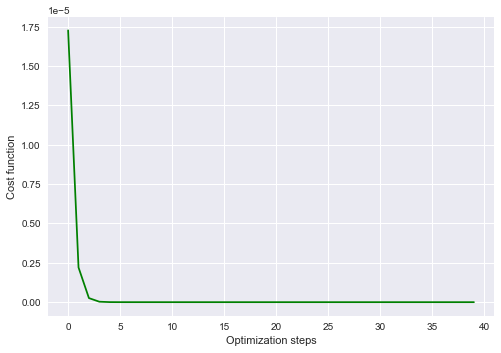

In [55]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Comparison of quantum and classical results
===========================================

Since the specific problem considered in this tutorial has a small size,
we can also solve it in a classical way and then compare the results
with our quantum solution.


Classical algorithm
===================

To solve the problem in a classical way, we use the explicit matrix
representation in terms of numerical NumPy arrays.


In [56]:
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(2**n_qubits)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)
A_3 = np.kron(np.kron(Id, X), Id)

A_num = c[0] * A_0 + c[1] * A_1 + c[2] * A_2 + c[3] * A_3
b = np.ones(2**n_qubits) / np.sqrt(2**n_qubits)

We can print the explicit values of $A$ and $b$:


In [57]:
print("A = \n", A_num)
print("b = \n", b)

A = 
 [[1. 0. 1. 0. 4. 0. 0. 0.]
 [0. 1. 0. 1. 0. 4. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0.]
 [4. 0. 0. 0. 1. 0. 1. 0.]
 [0. 4. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1.]]
b = 
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


The solution can be computed via a matrix inversion:


In [58]:
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

Finally, in order to compare x with the quantum state $|x\rangle$, we
normalize and square its elements.


In [59]:
c_probs = (x / np.linalg.norm(x)) ** 2

Preparation of the quantum solution
===================================


Given the variational weights `w` that we have previously optimized, we
can generate the quantum state $|x\rangle$. By measuring $|x\rangle$ in
the computational basis we can estimate the probability of each basis
state.

For this task, we initialize a new PennyLane device and define the
associated *qnode* circuit.


In [60]:
dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x)
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

To estimate the probability distribution over the basis states we first
take `n_shots` samples and then compute the relative frequency of each
outcome.


In [61]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots

Comparison
==========

Let us print the classical result.


In [62]:
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.   0.   0.25 0.25 0.   0.   0.25 0.25]


The previous probabilities should match the following quantum state
probabilities.


In [63]:
print("|<x|n>|^2=\n", q_probs)

|<x|n>|^2=
 [0.       0.       0.250591 0.249094 0.       0.       0.250459 0.249856]


Let us graphically visualize both distributions.


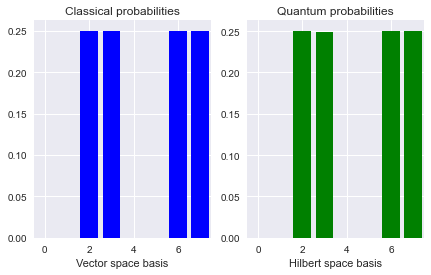

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

References
==========

1.  Carlos Bravo-Prieto, Ryan LaRose, Marco Cerezo, Yigit Subasi, Lukasz
    Cincio, Patrick J. Coles. \"Variational Quantum Linear Solver: A
    Hybrid Algorithm for Linear Systems.\"
    [arXiv:1909.05820](https://arxiv.org/abs/1909.05820), 2019.

About the author
================
